In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

# load data

## 파일 설명
- sales_train.csv- 훈련 세트. 2013 년 1 월부터 2015 년 10 월까지의 일일 기록 데이터.  
test.csv- 테스트 세트. 이러한 상점과 제품의 2015 년 11 월 매출을 예측해야합니다.  
sample_submission.csv- 올바른 형식의 샘플 제출 파일.  
items.csv- 항목 / 제품에 대한 추가 정보.  
item_categories.csv-   항목 카테고리에 대한 추가 정보입니다.  
shops.csv- 상점에 대한 추가 정보.  
## 데이터 필드  
- ID-  테스트 세트 내에서 (Shop, Item) 튜플을 나타내는 Id  
shop_id- 상점의 고유 식별자  
item_id- 상품의 고유 식별자  
item_category_id- 항목 카테고리의 고유 식별자  
item_cnt_day- 판매 된 제품 수입니다. 이 측정 값의 월별 금액을 예측하고 있습니다.  
item_price- 상품의 현재 가격  
date  -dd / mm / yyyy 형식의 날짜  
date_block_num- 편의를 위해 사용되는 연속 된 월 번호. 2013 년 1 월은 0, 2013 년 2 월은 1, ..., 2015 년 10 월은 33입니다.  
item_name-  항목 이름  
shop_name- 상점 이름  
item_category_name- 항목 카테고리 이름  

In [12]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle/'

df_train = pd.read_csv(data_dir +'sales_train.csv')
df_test = pd.read_csv(data_dir +'test.csv')
df_items = pd.read_csv(data_dir +'items.csv')
df_item_categories = pd.read_csv(data_dir +'item_categories.csv')
df_shops = pd.read_csv(data_dir +'shops.csv')
sample_mission = pd.read_csv(data_dir + 'sample_submission.csv')

In [27]:
df_train.head(3)
df_test.tail(3)

,ID,shop_id,item_id
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [13]:
sample_mission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [28]:
df_items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [29]:
df_item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [30]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [32]:
sum(df_train.duplicated()), sum(df_test.duplicated()),sum(df_items.duplicated()), sum(df_item_categories.duplicated()), sum(df_shops.duplicated())

(6, 0, 0, 0, 0)

In [20]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [21]:
# 중복 제거
df_train.drop_duplicates(inplace=True)

In [22]:
# 중복 재확인
sum(df_train.duplicated())

0

In [23]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [24]:
df_test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

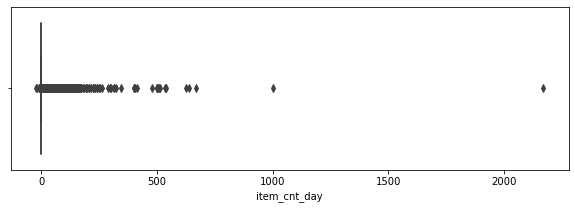

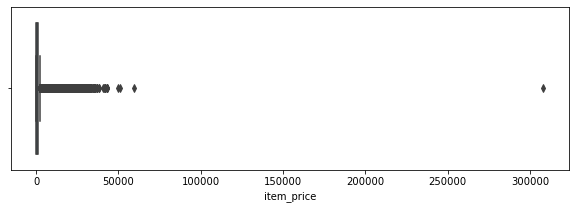

In [25]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

In [26]:
df_train = df_train[df_train.item_cnt_day < 500]
df_train = df_train[df_train.item_price < 50000]

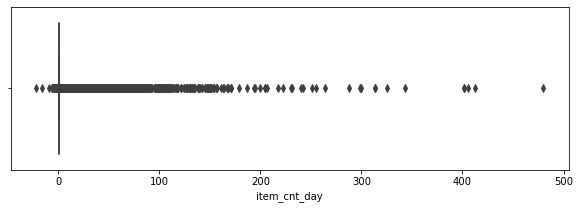

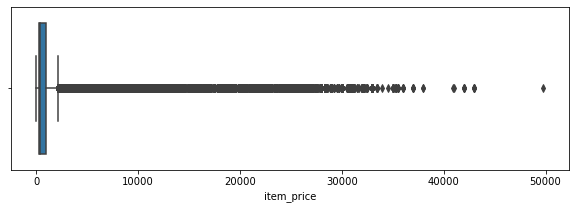

In [27]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

In [28]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06
mean,1.456986e+01,3.300178e+01,1.019721e+04,8.907121e+02,1.239344e+00
std,9.422973e+00,1.622696e+01,6.324294e+03,1.719911e+03,1.923299e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,4.800000e+02


In [29]:
df_train = df_train[df_train.item_cnt_day >= 0]
df_train = df_train[df_train.item_price >= 0]

In [30]:
df_shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [31]:
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [32]:
df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [33]:
df_shops.head(2)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск


In [34]:
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

In [35]:
df_shops.city.value_counts()

Москва              13
Якутск               4
Тюмень               3
Воронеж              3
РостовНаДону         3
СПб                  2
Самара               2
Уфа                  2
Новосибирск          2
Красноярск           2
Жуковский            2
Н.Новгород           2
Казань               2
Интернет-магазин     1
Адыгея               1
Коломна              1
Вологда              1
Химки                1
Цифровой             1
Мытищи               1
Выездная             1
Калуга               1
Омск                 1
Ярославль            1
Сургут               1
Чехов                1
СергиевПосад         1
Томск                1
Волжский             1
Балашиха             1
Курск                1
Name: city, dtype: int64

In [36]:

city_encoder = LabelEncoder()
df_shops['city_code'] = city_encoder.fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id', 'city_code']]
df_shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [37]:
df_item_categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [38]:
type_encoder = LabelEncoder()
df_item_categories['split_name'] = df_item_categories['item_category_name'].str.split(' - ')
df_item_categories['type'] = df_item_categories['split_name'].map(lambda x: x[0].strip())
df_item_categories['type_code'] = type_encoder.fit_transform(df_item_categories['type'])

In [39]:
df_item_categories.head(2)

,item_category_name,item_category_id,split_name,type,type_code
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1


In [40]:
subtype_encoder = LabelEncoder()
df_item_categories['subtype'] = df_item_categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_item_categories['subtype_code'] = subtype_encoder.fit_transform(df_item_categories['subtype'])
df_item_categories = df_item_categories[['item_category_id', 'type_code', 'subtype_code']]

In [41]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


In [42]:
df_items.drop(['item_name'], axis=1, inplace=True)

In [43]:
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


In [44]:
df_shops.head(2)

,shop_id,city_code
0,0,29
1,1,29


In [45]:

df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


In [46]:
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


In [47]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [48]:
df_test.shop_id.value_counts()

2     5100
47    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
48    5100
3     5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
36    5100
35    5100
34    5100
31    5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
59    5100
Name: shop_id, dtype: int64

In [49]:
len(df_test.shop_id.unique())

42

In [50]:
len(set(df_test.item_id) - set(df_train.item_id))

363

In [51]:
len(df_test) == 42*5100

True

In [52]:
num_date_block_num = len(df_train.date_block_num.value_counts())
num_date_block_num

34

In [53]:
ts = time.time()
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = df_train[df_train.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
time.time()-ts

12.51188588142395

In [ ]:
matrix.head()

In [ ]:
sales = df_train[df_train.date_block_num == 1]

In [ ]:
sales.shop_id.unique()

In [ ]:
sales.item_id.unique()

In [ ]:
list(itertools.product([1], sales.shop_id.unique(), sales.item_id.unique()))

In [ ]:

df_train.head()

In [ ]:

df_train['revenue'] = df_train['item_price'] * df_train['item_cnt_day']

In [ ]:
df_train.head()

In [ ]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

In [ ]:
group.head()

In [ ]:
group.columns = ['item_cnt_month']

In [ ]:

group.head()

In [ ]:
group.reset_index(inplace=True)

In [ ]:
group.head()

In [ ]:
matrix.head()

In [ ]:
matrix = pd.merge(matrix, group, how='left')

In [ ]:

matrix.head()

In [ ]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 30).astype(np.float16))

In [ ]:
matrix.head()

In [ ]:
df_test.head(2)

In [ ]:
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)

In [ ]:
df_test.head(2)

In [ ]:
matrix = pd.concat([matrix, df_test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # for 34 month
matrix.head()

In [ ]:
matrix.tail()

In [ ]:

matrix = pd.merge(matrix, df_shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, df_items, on=['item_id'], how='left')
matrix = pd.merge(matrix, df_item_categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [ ]:
matrix.head()

In [ ]:
matrix[matrix['date_block_num'] == 0]

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [ ]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']

In [ ]:
group.head()

In [ ]:
group.reset_index(inplace=True)

In [ ]:
group.head()

In [ ]:
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix.head()

In [ ]:
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')

In [ ]:
matrix.tail()

In [ ]:
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
matrix.tail()

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [ ]:

group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [ ]:

group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = df_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [ ]:

group = df_train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [ ]:
lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
for lag in lags:
    matrix['delta_price_lag_'+str(lag)] = \
    (matrix['date_item_avg_item_price_lag_'+str(lag)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [ ]:

def select_trend(row):
    for lag in lags:
        if row['delta_price_lag_'+str(lag)]:
            return row['delta_price_lag_'+str(lag)]
    return 0
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [ ]:

features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]

In [ ]:
matrix.drop(features_to_drop, axis=1, inplace=True)